<a href="https://colab.research.google.com/github/chitra-psg/house_price_prediction/blob/main/HousingPrediction_RidgeLasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
# Import the required modules
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# for model evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Adding a constant variable 
import statsmodels.api as sm  
#%matplotlib inline

# Configurations
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# **Common Functions**

In [115]:
# Function for Analysis of Categorical column
def AnalyseCategoricalColumns(df_data, i, col_i,col_o):
    plt.figure(i)
    variables = df_data[[col_i]].nunique()
    plt.figure(figsize=(variables,variables/1.77))
    my_order = df_data[[col_i,col_o]].groupby(by=[col_i])[col_o].median().sort_values(ascending=True)
    sns.boxplot(x=col_i, y=col_o, data=df_data[[col_i,col_o]], order=my_order.index)

In [116]:
def CreateLRModel(df_X_train, df_y_train, lst_columns):
  # Creating X_test dataframe with RFE selected variables
  df_X_train_rfe = df_X_train[lst_columns] 
  df_X_train_rfe = sm.add_constant(df_X_train_rfe)
  # Running the linear model
  lm = sm.OLS(df_y_train, df_X_train_rfe).fit()
  # Calculate VIF to check for multi collinearity
  vif = pd.DataFrame()
  df_X = df_X_train_rfe.drop(['const'], axis=1)
  vif['Features'] = df_X.columns
  vif['VIF'] = [variance_inflation_factor(df_X.values, i) for i in range(df_X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  #Let's see the summary of our linear model
  print(lm.summary())
  #Let's view the summary of VIF 
  print(vif)
  return lm

# **Data Preparation**

In [117]:
# Load the source data from GitHub into dataframe for analysis
# Load all column data in and then determine data type : low_memory=False
df_house = pd.read_csv("https://github.com/chitra-psg/house_price_prediction/blob/main/train.csv?raw=True",  low_memory=False)
df_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [118]:
# Check data types of fields
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [119]:
# Convert few categorical fields to object data type to be able to create dummies later.
df_house[['MSSubClass', 'OverallQual', 'OverallCond']] = df_house[['MSSubClass', 'OverallQual', 'OverallCond']].astype('object')

In [120]:
# Check for NULLs
df_house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [121]:
## Drop the columns which have mostly NULLs
df_house.drop(['PoolQC', 'Fence', 'MiscFeature', 'Alley' ], axis=1, inplace=True)

In [122]:
# Check for NULLs
df_house.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

In [123]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

In [124]:
#Cateforical fields with NA to be filled with None
col_NA_none = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','FireplaceQu']

df_house.loc[:, col_NA_none] = df_house.loc[:, col_NA_none].fillna('None')


In [125]:
#Check for NULLs again
df_house.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

In [126]:
## Create new column for the age of the house
df_house['AgeOfHouseWhenSold'] = df_house['YrSold'] - df_house['YearBuilt']

#Numerical fields with NA to be filled with 0
col_NA_num = ['GarageYrBlt']
df_house.loc[:, col_NA_num] = df_house.loc[:, col_NA_num].fillna(0)

#df_house['GarageAgeWhenSold'] = (df_house['YrSold']- df_house['GarageYrBlt']).fillna(0)

In [127]:
## Drop the columns 
#df_house.drop(['YrSold', 'YearBuilt','Id', 'GarageYrBlt'], axis=1, inplace=True)

df_house.drop(['YrSold', 'YearBuilt','Id'], axis=1, inplace=True)

In [128]:
print(df_house.shape)

(1460, 75)


In [129]:
#Check for NULLs again
df_house.isnull().sum()

MSSubClass              0
MSZoning                0
LotFrontage           259
LotArea                 0
Street                  0
LotShape                0
LandContour             0
Utilities               0
LotConfig               0
LandSlope               0
Neighborhood            0
Condition1              0
Condition2              0
BldgType                0
HouseStyle              0
OverallQual             0
OverallCond             0
YearRemodAdd            0
RoofStyle               0
RoofMatl                0
Exterior1st             0
Exterior2nd             0
MasVnrType              0
MasVnrArea              8
ExterQual               0
ExterCond               0
Foundation              0
BsmtQual                0
BsmtCond                0
BsmtExposure            0
BsmtFinType1            0
BsmtFinSF1              0
BsmtFinType2            0
BsmtFinSF2              0
BsmtUnfSF               0
TotalBsmtSF             0
Heating                 0
HeatingQC               0
CentralAir  

In [130]:
# LotFrontage and MasVnrArea has Nulls.
col_impute_mean = ['MasVnrArea', 'LotFrontage']
#Technique 1: Using mean to impute the missing values
for i in col_impute_mean:
  df_house.loc[df_house.loc[:,i].isnull(),i]=df_house.loc[:,i].mean()


In [131]:
# Checking for percentage of missing values per column
print(df_house.shape)
print(((df_house.isnull().sum()/df_house.shape[0])*100).round(2))

(1460, 75)
MSSubClass            0.0
MSZoning              0.0
LotFrontage           0.0
LotArea               0.0
Street                0.0
LotShape              0.0
LandContour           0.0
Utilities             0.0
LotConfig             0.0
LandSlope             0.0
Neighborhood          0.0
Condition1            0.0
Condition2            0.0
BldgType              0.0
HouseStyle            0.0
OverallQual           0.0
OverallCond           0.0
YearRemodAdd          0.0
RoofStyle             0.0
RoofMatl              0.0
Exterior1st           0.0
Exterior2nd           0.0
MasVnrType            0.0
MasVnrArea            0.0
ExterQual             0.0
ExterCond             0.0
Foundation            0.0
BsmtQual              0.0
BsmtCond              0.0
BsmtExposure          0.0
BsmtFinType1          0.0
BsmtFinSF1            0.0
BsmtFinType2          0.0
BsmtFinSF2            0.0
BsmtUnfSF             0.0
TotalBsmtSF           0.0
Heating               0.0
HeatingQC             0.0
C

In [132]:
# Separating numerical and categorical fields for analysisng them separately using the provided Data Dictionary.

# OUTCOME COLUMN:
col_y = 'SalePrice'

df_X_house = df_house.drop("SalePrice" ,axis= 1)

col_X_category = df_X_house.select_dtypes(include=['object']).columns
col_X_numeric = df_X_house.select_dtypes(include=['int64','float64']).columns

print(col_X_category,'\n',col_X_numeric,'\n')

# Listing distinct variables for each Categorical columns to address issues if any
for col in col_X_category:
    print(col,' : ',df_house[col].unique())

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'], dtype='object') 
 Index(['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'S

# **Exploratory Data Analysis**

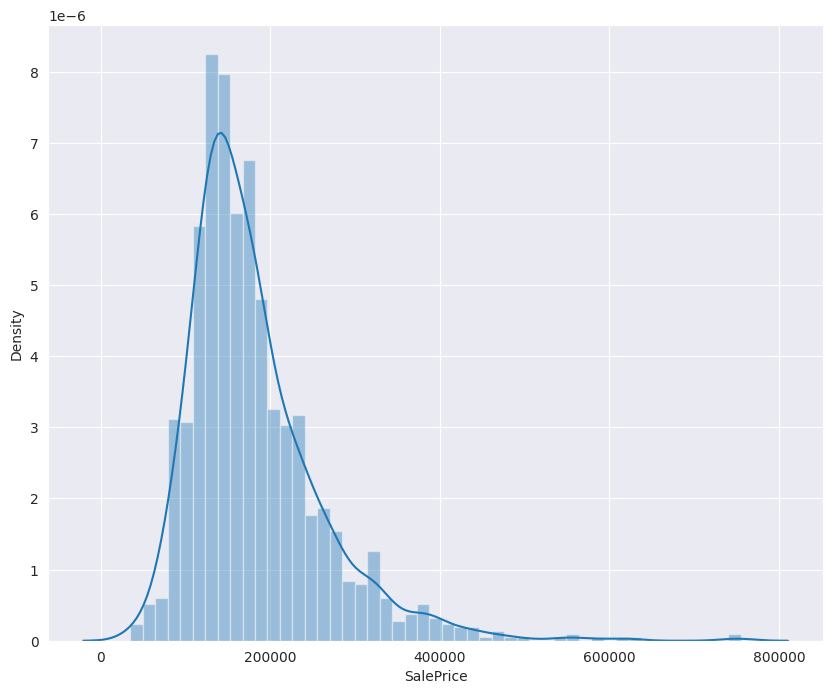

In [133]:
## First let's analyse the target variable 'SalePrice'
plt.figure(figsize=[10,8])
sns.set_style('darkgrid')
sns.distplot(df_house['SalePrice']);
#Findings: Values are skewed

In [134]:
## Log transform the target variable
df_house['SalePrice'] = np.log(df_house['SalePrice'])

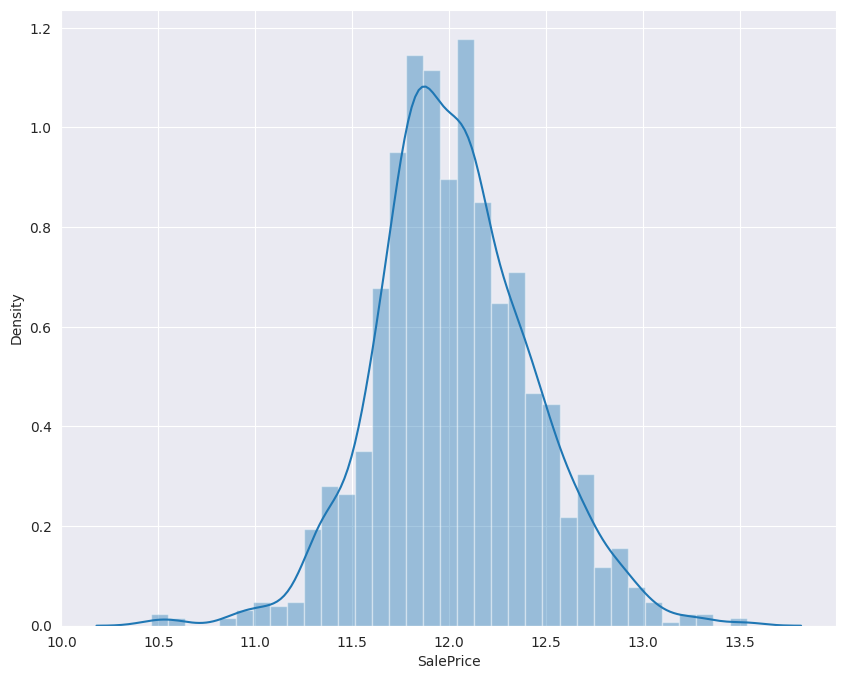

In [135]:
## Lets re- analyse the target variable 'SalePrice'
plt.figure(figsize=[10,8])
sns.set_style('darkgrid')
sns.distplot(df_house['SalePrice']);
# Findings : Its normally distributes now

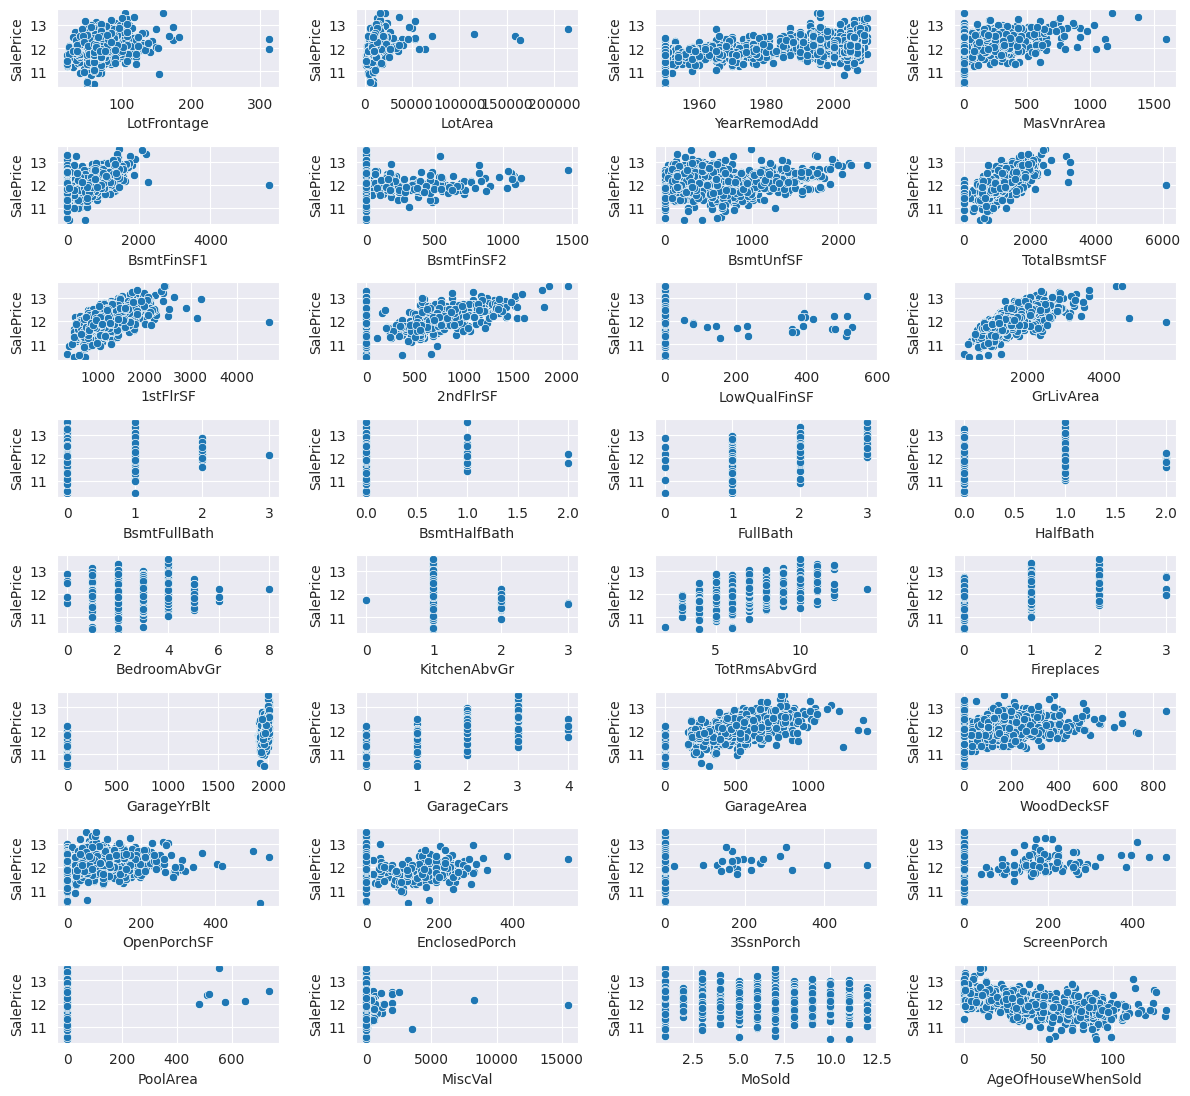

In [136]:
fig=plt.subplots(figsize=(12, 12))

for i, col in enumerate(col_X_numeric):
    plt.subplot(9, 4, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.scatterplot(x=col, y=col_y, data=df_house) 
    plt.tight_layout()

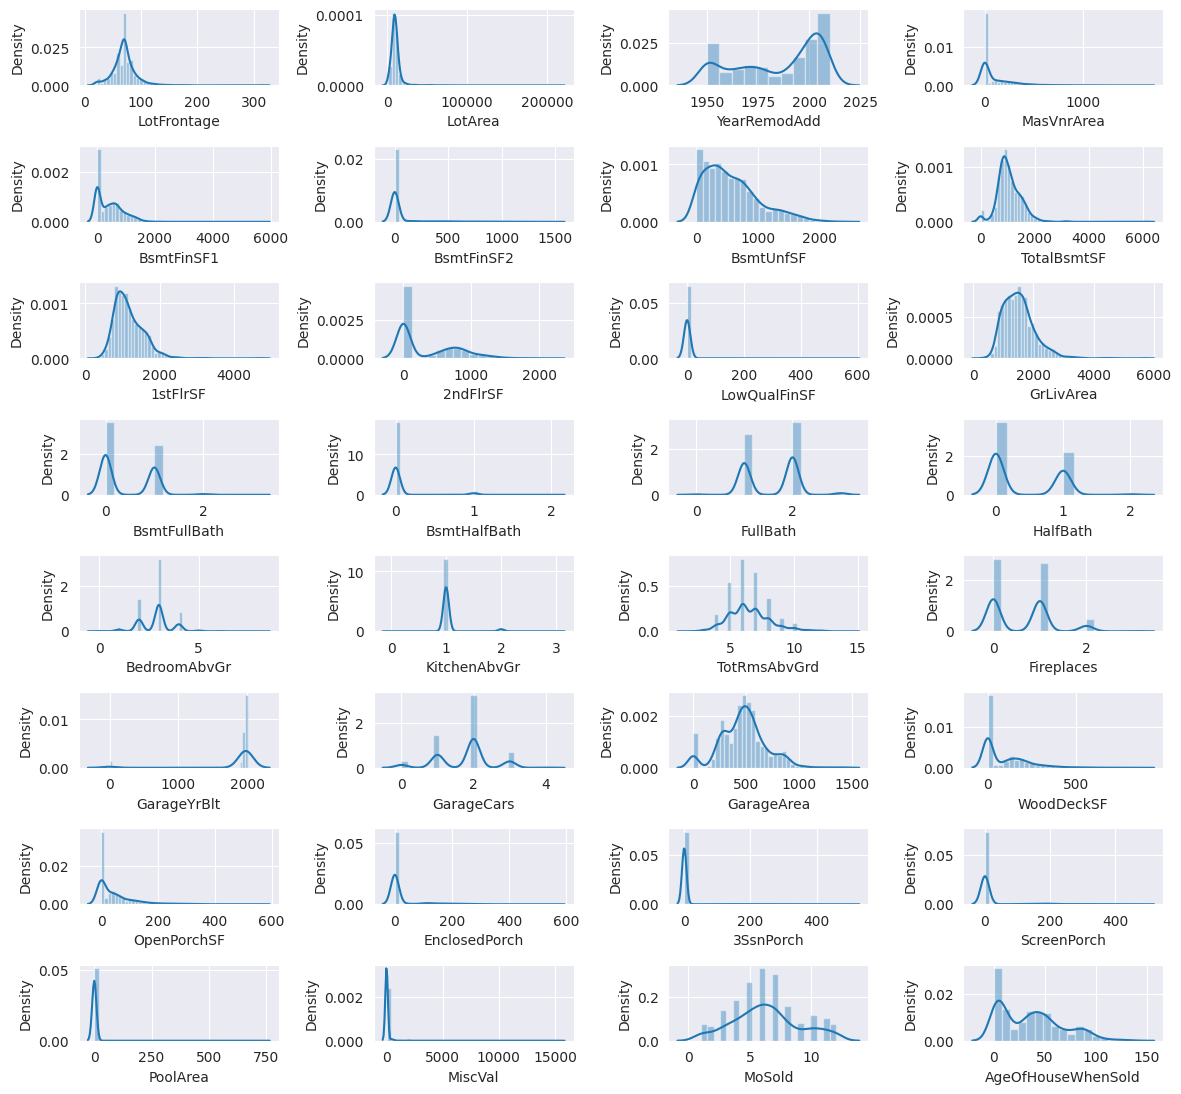

In [138]:
fig=plt.subplots(figsize=(12, 12))

for i, col in enumerate(col_X_numeric):
    plt.subplot(9, 4, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.distplot(df_house[col])
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

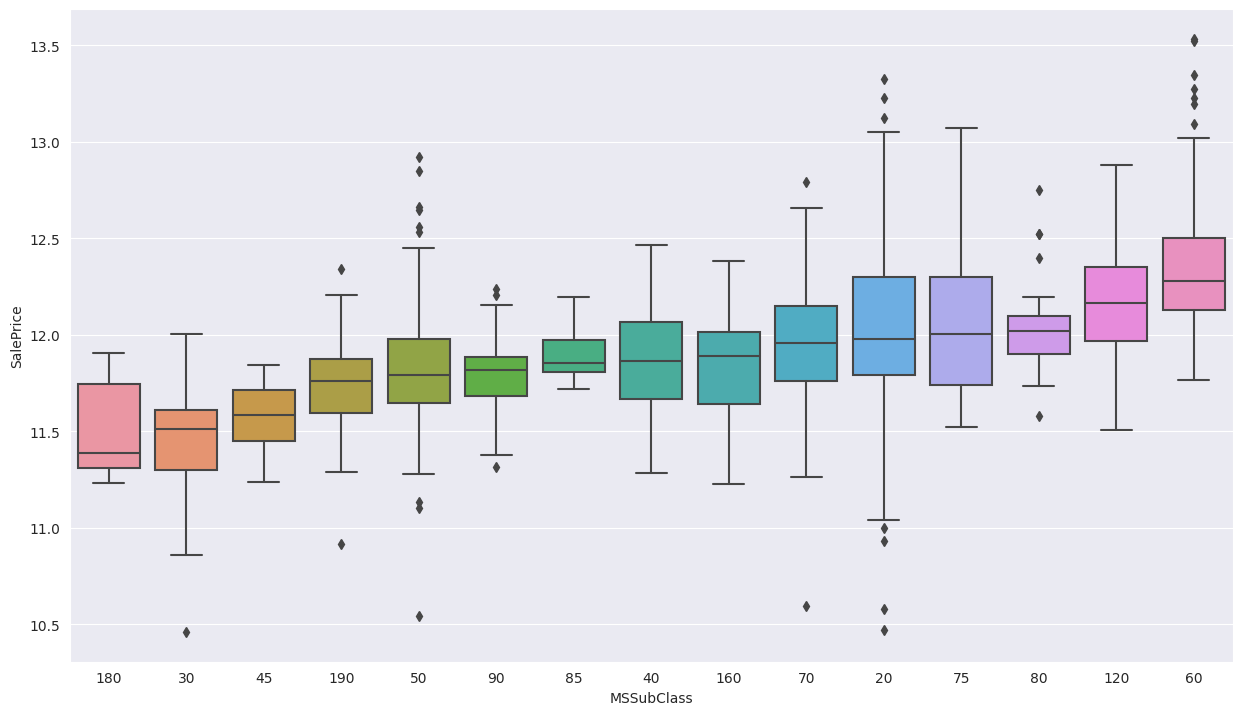

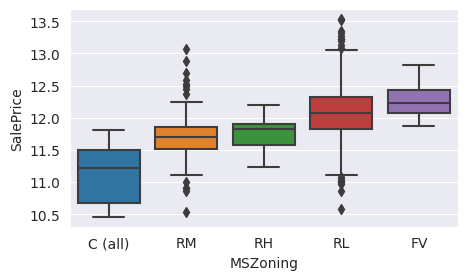

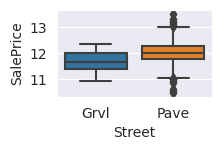

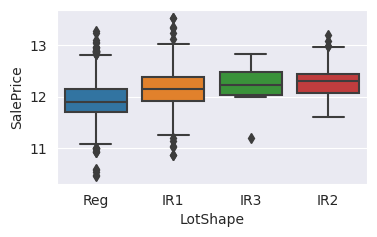

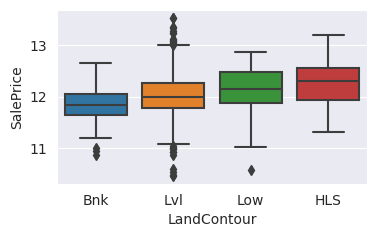

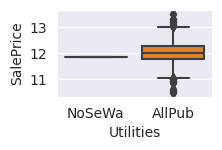

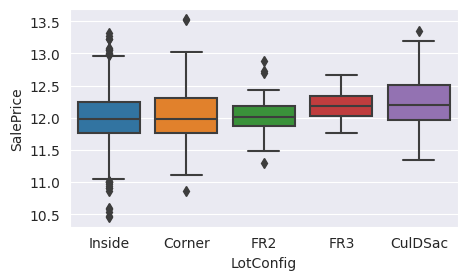

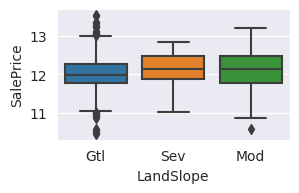

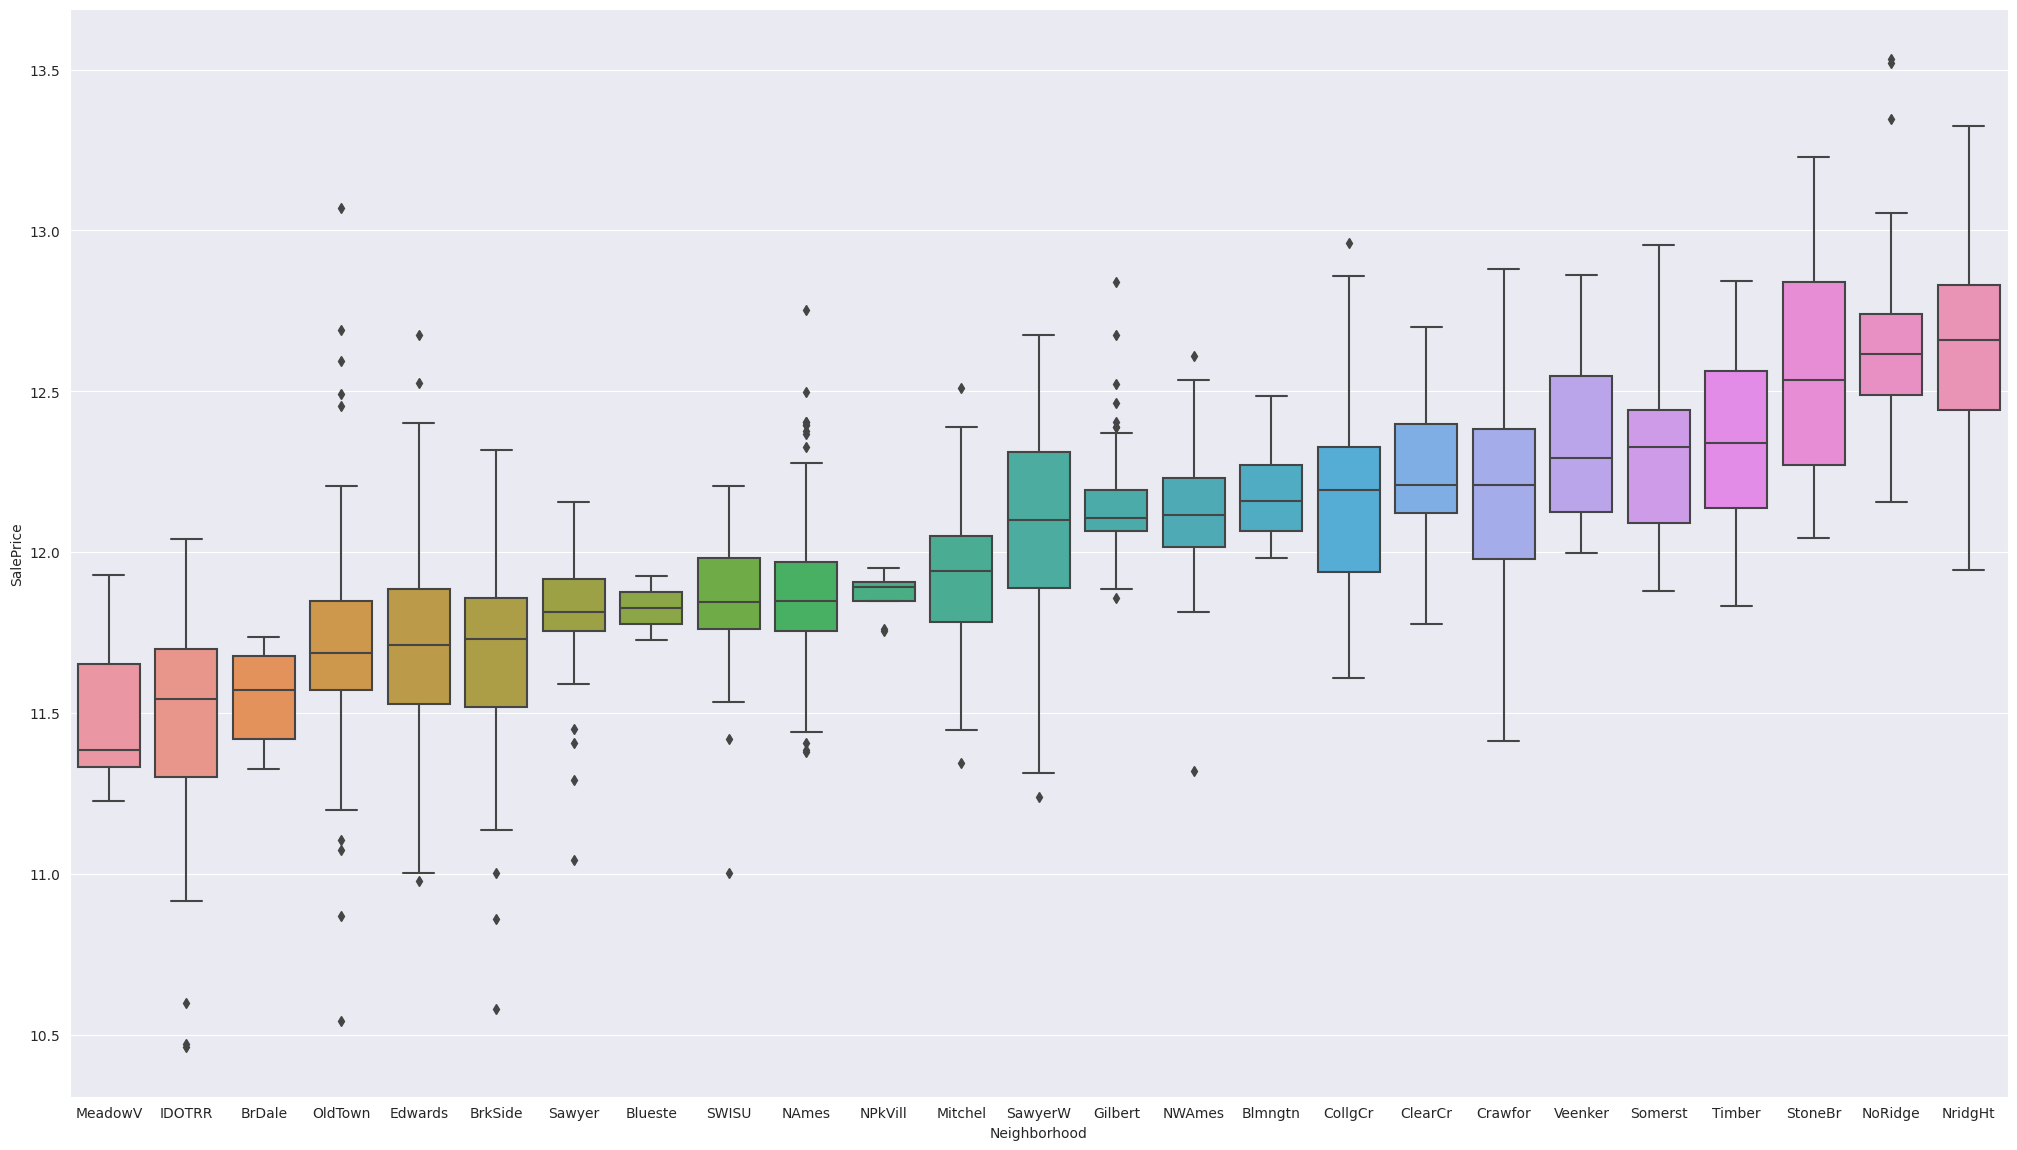

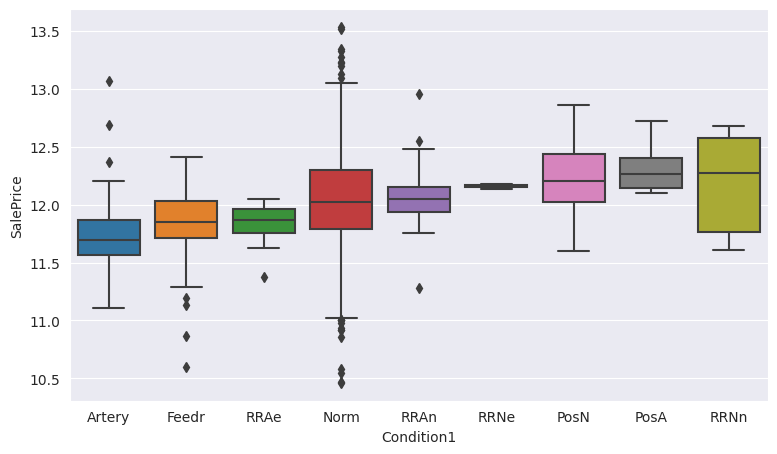

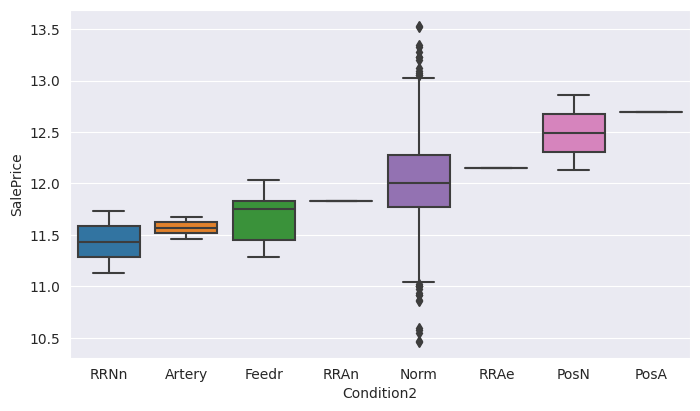

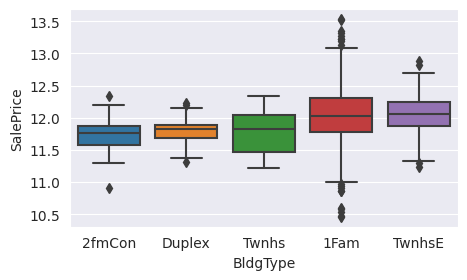

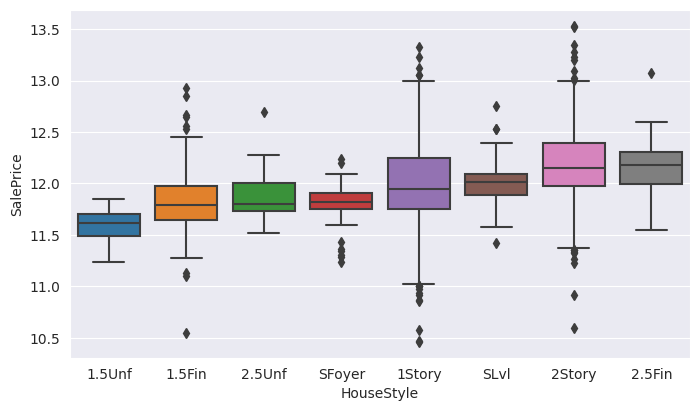

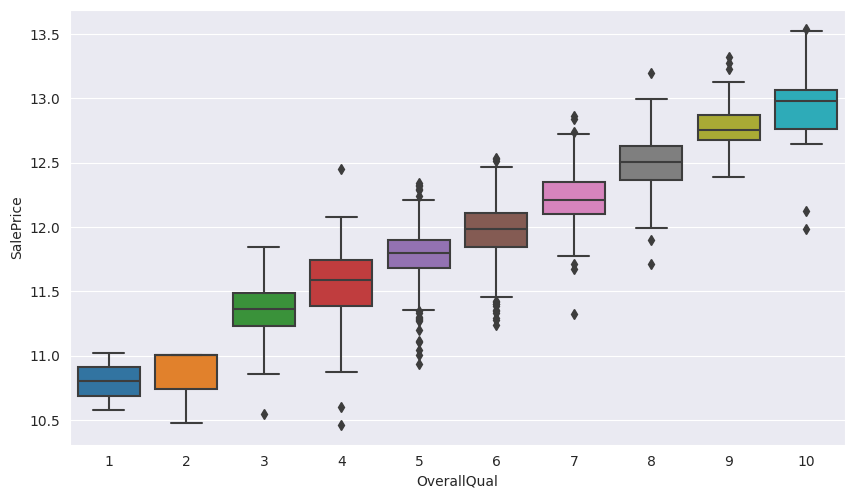

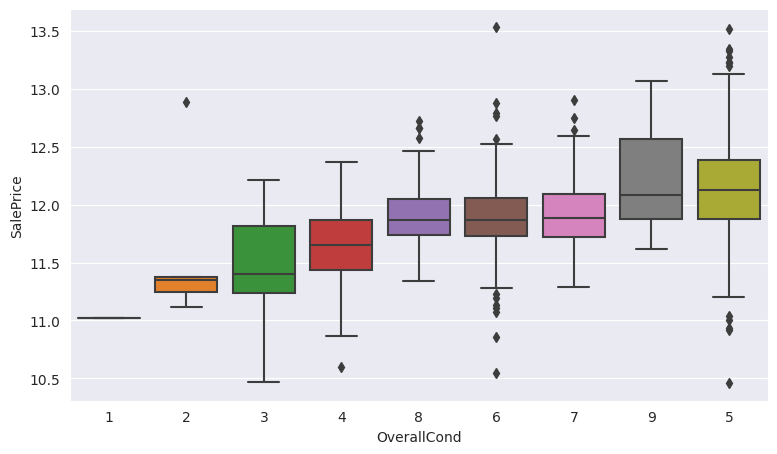

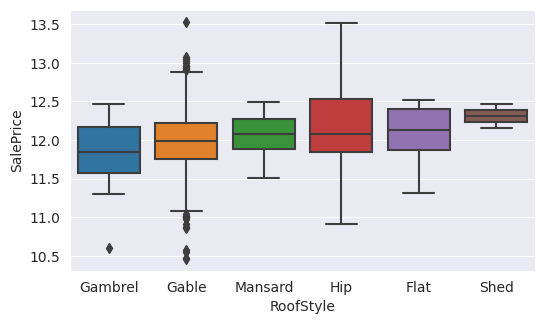

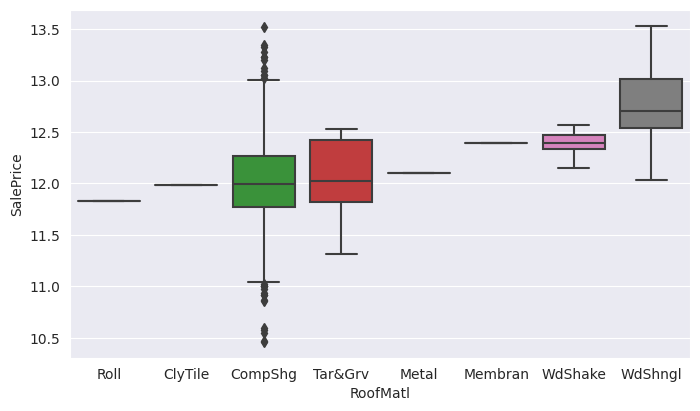

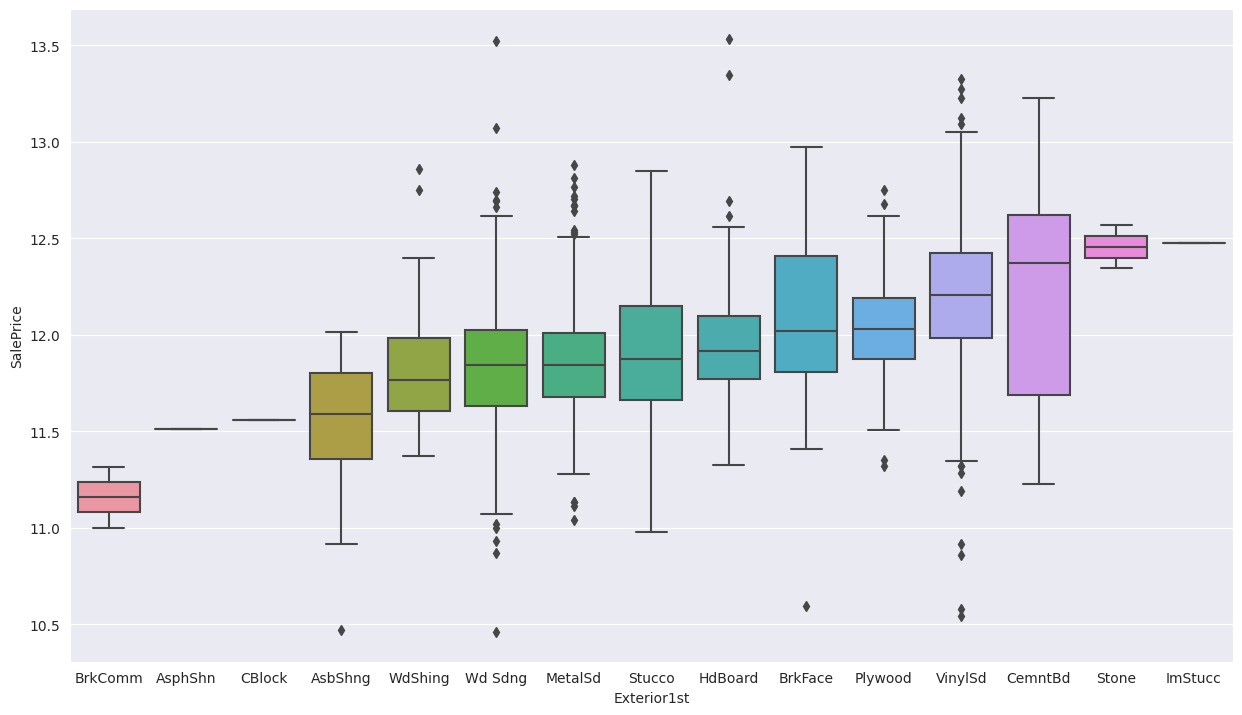

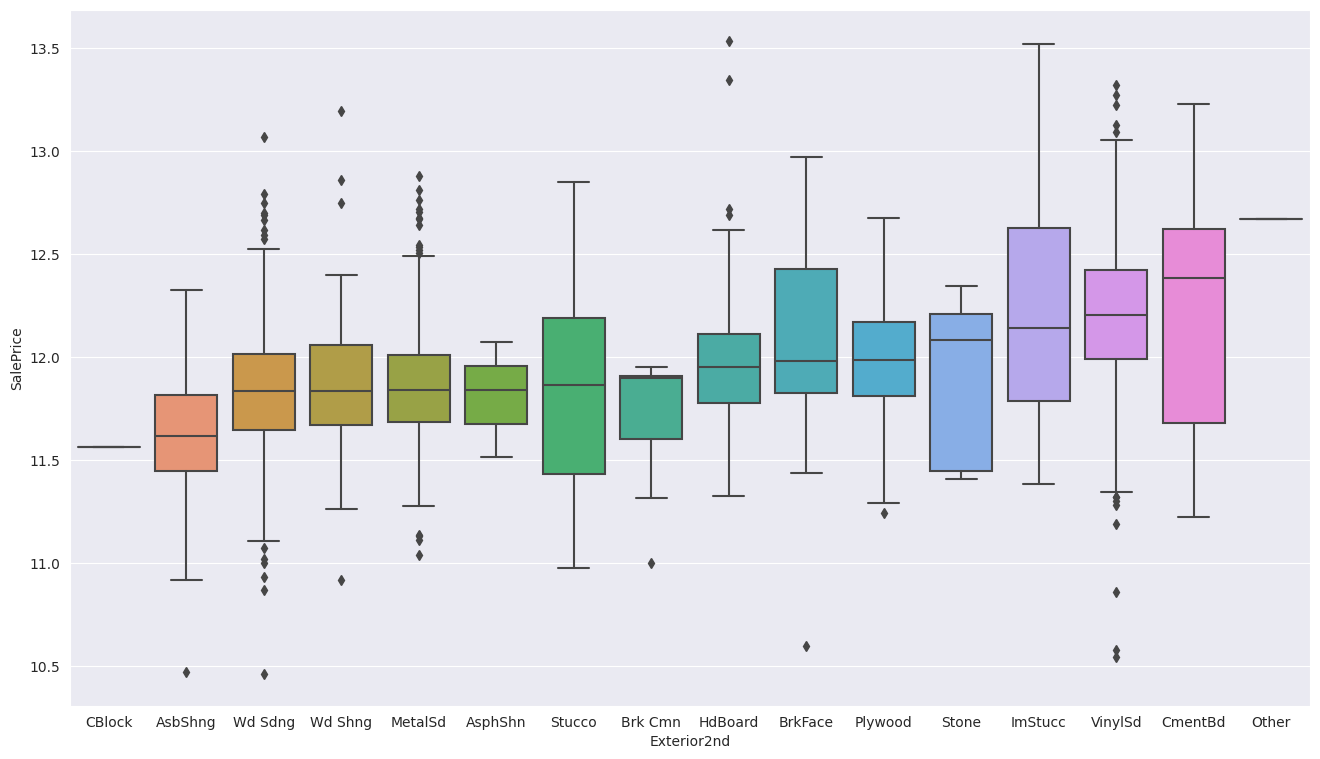

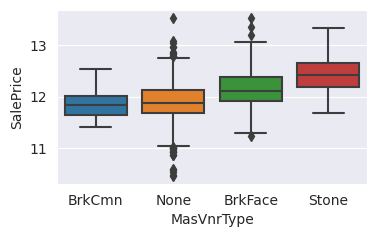

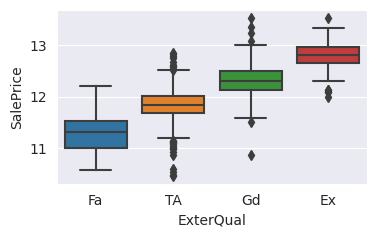

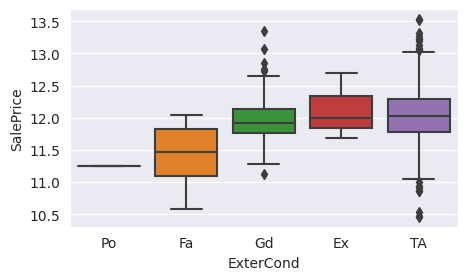

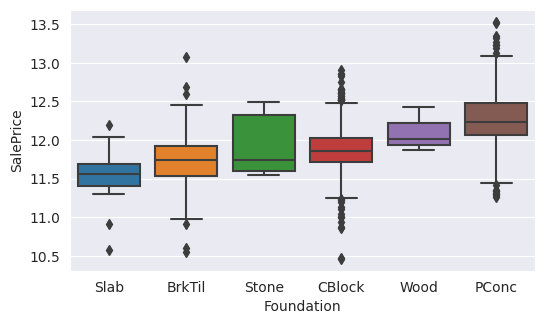

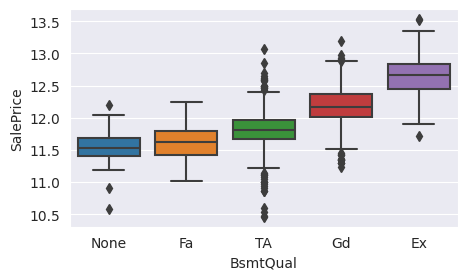

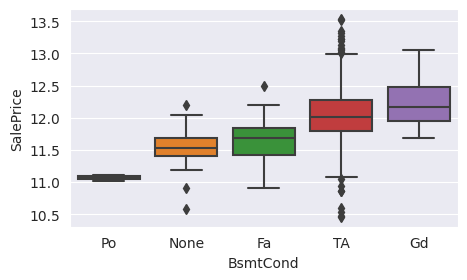

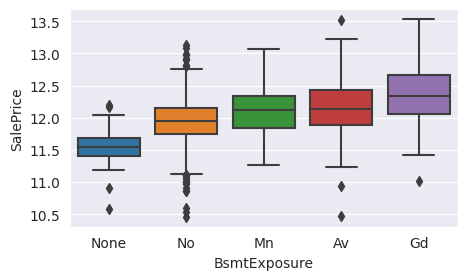

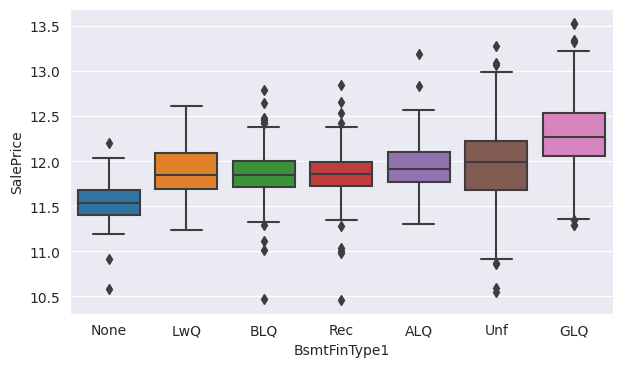

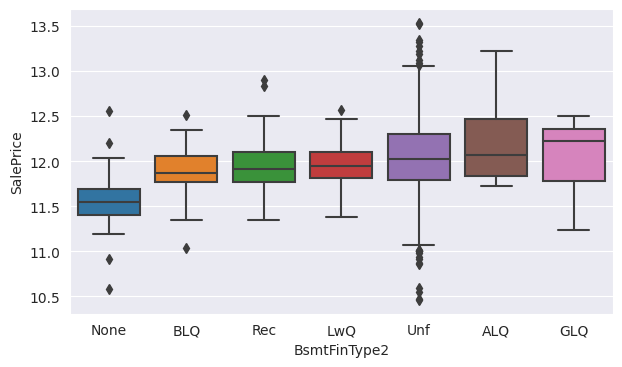

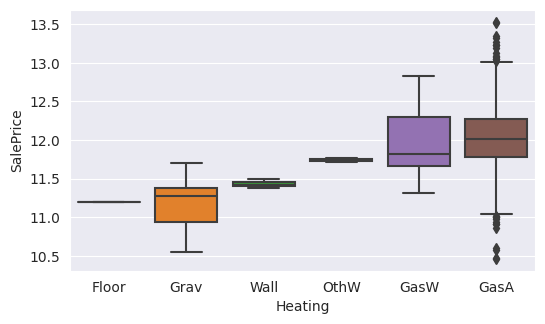

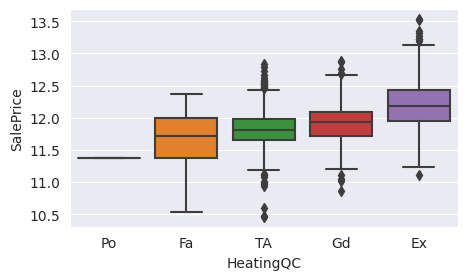

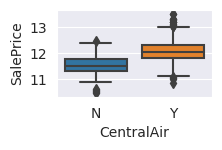

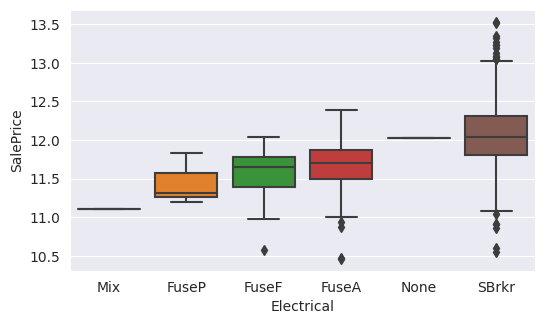

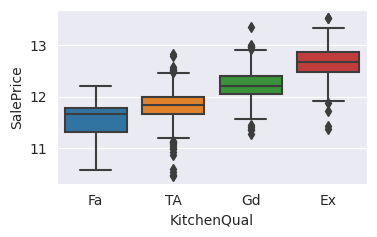

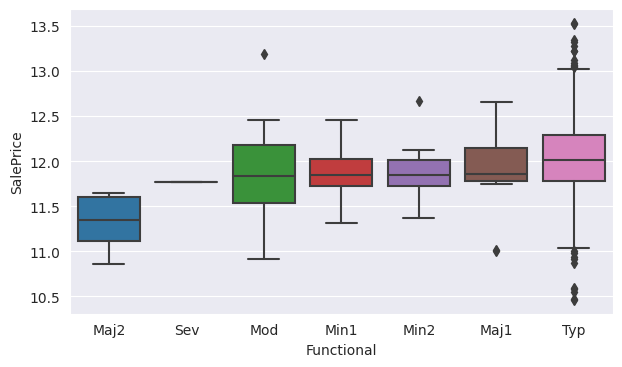

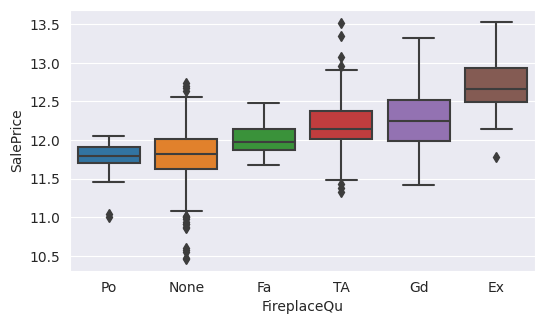

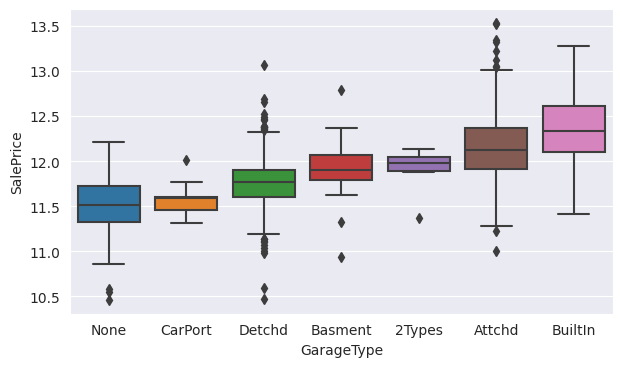

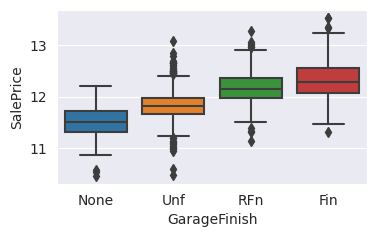

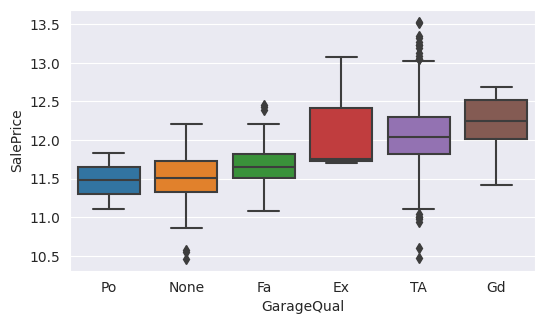

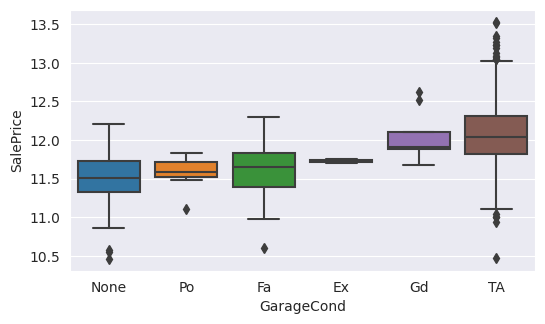

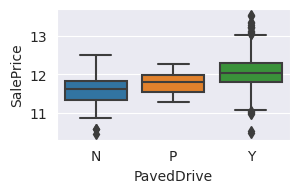

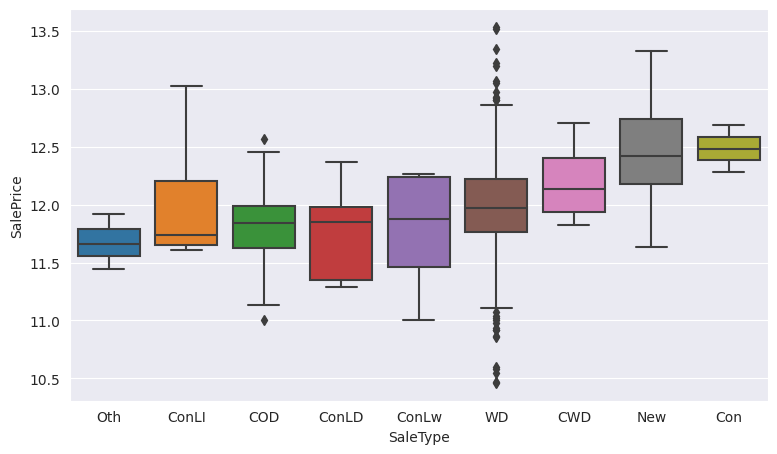

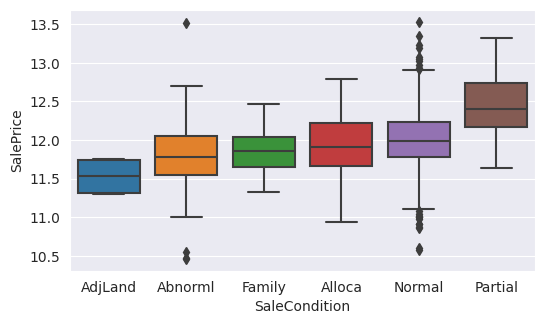

In [139]:
# CATEGORICAL COLUMN ANALYSIS
for i, col in enumerate(col_X_category):
    AnalyseCategoricalColumns(df_house, i, col, col_y)

In [140]:
# Higher Overall Qual has higher Sale Price
# BsmtQual and Exterior Qual = Ex has high Sale PRice
# BsmtCond and Exposure = Gd has better Sale Price
# Sale Condition = Partial has better Sale Price
# Sales Tyepe = New, Con has relatively better Sale PRice
# GarageType = builtin has better Sal and No Garage has lower Sale Price
# Fire Place Ex has better Sale PRice and FirePlace = Po has lower Sale PRice
# Kitchen Qual = Ex has higher Sale PRice and Fa has lower Sale Price
# Heating QC = Ex has higher Sale PRice and Po has lower Sales PRice
# BsmtFinType1 = GLQ has higher Sale PRice
# 


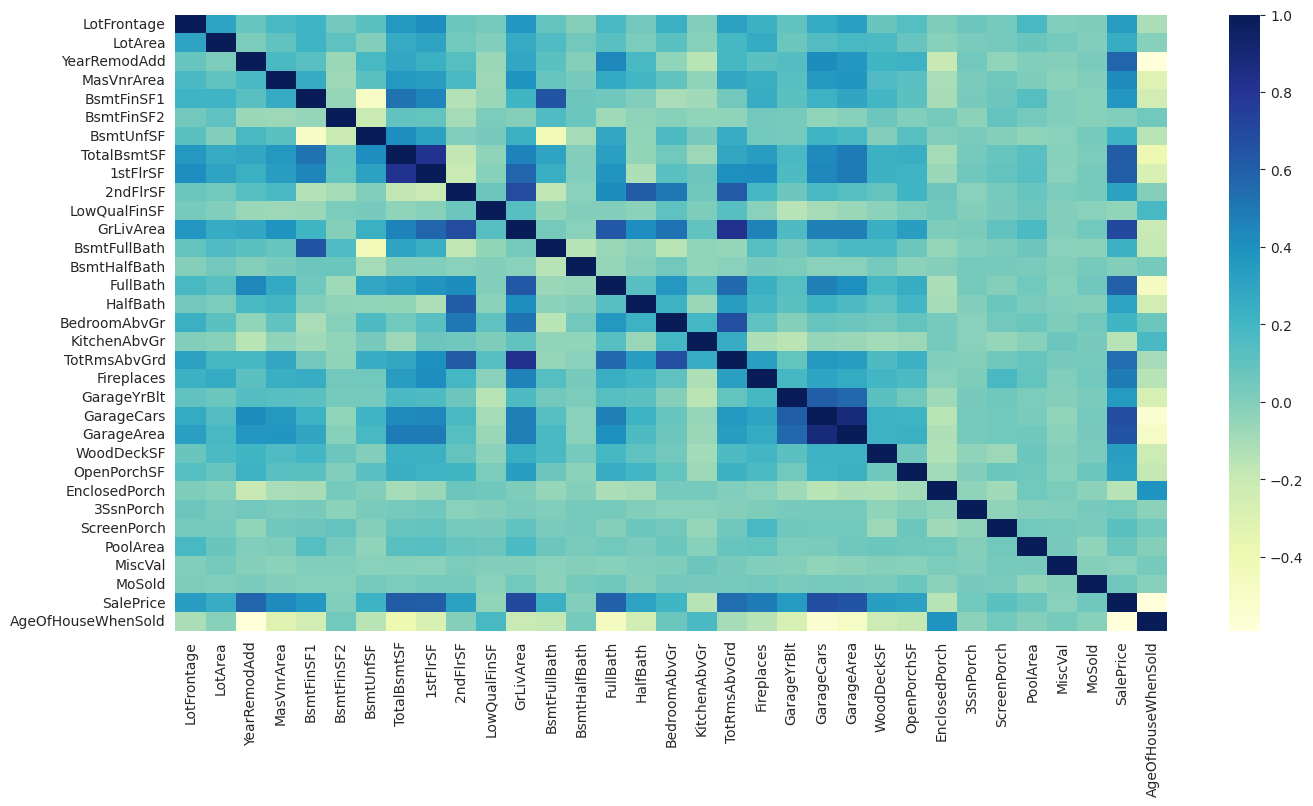

In [141]:
plt.figure(figsize=(16,8))
# heatmap
sns.heatmap(df_house.corr(), cmap="YlGnBu", annot=False)
plt.show()

# Summary
1. There is linear relationship between independent variable and output variable
2. There is collinearity between independent variables. Notice the darker shades of blue in the heatmap.

# **Data Prep for Modelling**

In [142]:
df_house.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,AgeOfHouseWhenSold
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,WD,Normal,12.247694,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,WD,Normal,12.109011,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,WD,Normal,12.317167,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,WD,Abnorml,11.849398,91
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,WD,Normal,12.429216,8


### Create dummies for categorical fields

In [143]:
#Create dummy columns for categorical variables and drop the first column
df_house = pd.get_dummies(df_house, drop_first=True)

df_house.info()
df_house.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 275 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(4), int64(29), uint8(242)
memory usage: 721.6 KB


,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeOfHouseWhenSold,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,Ga

In [144]:
df_X_house = df_house.drop("SalePrice" ,axis= 1)

col_X_category = df_X_house.select_dtypes(include=['object']).columns
col_X_numeric = df_X_house.select_dtypes(include=['int64','float64']).columns


In [145]:
# Preparing Test and Train Set

y = df_house.loc[:, col_y]
X = df_house.loc[:, df_house.columns != col_y]

## Splitting X and y into 80% train data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# scale
scaler = StandardScaler()

## Scale the numerical columns 
X_train[col_X_numeric] = scaler.fit_transform(X_train[col_X_numeric])
X_test[col_X_numeric] = scaler.transform(X_test[col_X_numeric])


In [146]:
# linear regression with all predictors
lm_simple = LinearRegression()
lm_simple.fit(X_train, y_train)

# predict train
y_train_pred = lm_simple.predict(X_train)
print('Train R2 Score :', metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
# predict test
y_test_pred = lm_simple.predict(X_test)
print('Test R2 Score : ', metrics.r2_score(y_true=y_test, y_pred=y_test_pred))


Train R2 Score : 0.9479324600687745
Test R2 Score :  -9.56190246607974e+19


In [147]:
# Simple Linear Regression model parameters
simple_model_parameters = list(lm_simple.coef_)
simple_model_parameters.insert(0, lm_simple.intercept_)
simple_model_parameters = [round(x, 3) for x in simple_model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
sorted(list(zip(simple_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(171097223407.258, 'BsmtFinSF1'),
 (166361497580.405, 'BsmtUnfSF'),
 (-164241479543.152, 'TotalBsmtSF'),
 (132623915752.445, 'GrLivArea'),
 (-111163190024.379, '2ndFlrSF'),
 (-97786407118.103, '1stFlrSF'),
 (58968168688.606, 'BsmtFinSF2'),
 (-42460797042.593, 'MSSubClass_90'),
 (42460797042.524, 'BldgType_Duplex'),
 (-41671868655.172, 'BldgType_Twnhs'),
 (-41671868655.153, 'BldgType_TwnhsE'),
 (41671868655.116, 'MSSubClass_120'),
 (41671868655.085, 'MSSubClass_180'),
 (41671868655.008, 'MSSubClass_160'),
 (-12110182377.324, 'LowQualFinSF'),
 (-9507044585.56, 'Exterior1st_CBlock'),
 (9507044585.507, 'Exterior2nd_CBlock'),
 (3203279088.919, 'GarageQual_None'),
 (-2753577563.548, 'GarageFinish_None'),
 (-841753991.832, 'GarageCond_None'),
 (654778339.089, 'constant'),
 (-654778331.182, 'OverallCond_3'),
 (-654778331.085, 'OverallCond_4'),
 (-654778331.051, 'OverallCond_5'),
 (-654778331.003, 'OverallCond_6'),
 (-654778331.001, 'OverallCond_2'),
 (-654778330.983, 'OverallCond_7'),
 (-6547

Summary:

Simple Linear Regression gave us a complex model with most of the coefficients as non-zero values.
Simple Linear Regression has not helped us in the feature selection.

R2 Socre on test data us poor

#RFE

In [148]:

# Running RFE with the output number of the variable equal to 20
lm_rfe = LinearRegression()
lm_rfe.fit(X_train, y_train)

rfe = RFE(lm_rfe, n_features_to_select = 30)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 208),
 ('LotArea', False, 133),
 ('YearRemodAdd', False, 121),
 ('MasVnrArea', False, 214),
 ('BsmtFinSF1', False, 63),
 ('BsmtFinSF2', False, 64),
 ('BsmtUnfSF', False, 65),
 ('TotalBsmtSF', False, 61),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 164),
 ('BsmtHalfBath', False, 234),
 ('FullBath', False, 169),
 ('HalfBath', False, 168),
 ('BedroomAbvGr', False, 199),
 ('KitchenAbvGr', False, 173),
 ('TotRmsAbvGrd', False, 245),
 ('Fireplaces', False, 193),
 ('GarageYrBlt', False, 122),
 ('GarageCars', False, 175),
 ('GarageArea', False, 103),
 ('WoodDeckSF', False, 197),
 ('OpenPorchSF', False, 238),
 ('EnclosedPorch', False, 218),
 ('3SsnPorch', False, 206),
 ('ScreenPorch', False, 188),
 ('PoolArea', False, 231),
 ('MiscVal', False, 244),
 ('MoSold', False, 233),
 ('AgeOfHouseWhenSold', False, 25),
 ('MSSubClass_30', False, 96),
 ('MSSubClass_40', False, 189),
 ('MSSubClass_45', 

In [149]:
ls_selected_col = X_train.columns[rfe.support_]
ls_selected_col

Index(['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Condition2_PosN', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallQual_10', 'OverallCond_3', 'RoofMatl_CompShg', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_BrkComm', 'ExterCond_Po', 'Heating_GasA', 'Heating_GasW', 'Functional_Maj2', 'Functional_Sev'], dtype='object')

In [150]:
lm_rfe = CreateLRModel(X_train, y_train,  ls_selected_col)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     196.4
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:06:57   Log-Likelihood:                 488.10
No. Observations:                1168   AIC:                            -916.2
Df Residuals:                    1138   BIC:                            -764.3
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   8.2514    

**Summary:**

R2 Score of this model is only 83%. The features selected have multicollinearity and hence needs refinement to choose appropriate features for the model.

In [151]:
def BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='ridge'):

  if model == 'ridge':
    model_estimator = Ridge()
  else:
    model_estimator = Lasso()

  model_gscv = GridSearchCV(estimator = model_estimator, 
                          param_grid = params, 
                          scoring= 'neg_mean_absolute_error', 
                          cv = 5, 
                          return_train_score=True,
                          verbose = 1)        
      
  model_gscv.fit(X_train, y_train)
  alpha = model_gscv.best_params_["alpha"]
  print("Optimum alpha for %s is %f" %(model, alpha))
  final_model = model_gscv.best_estimator_

  final_model.fit(X_train, y_train)
  y_train_pred = final_model.predict(X_train)
  y_test_pred = final_model.predict(X_test)
 
  # Model Evaluation
  print(model," Regression with ",alpha)
  print("===================================")
  print('R2 score (train) : ',r2_score(y_train,y_train_pred))
  print('R2 score (test) : ',r2_score(y_test,y_test_pred))
  print('RMSE (train) : ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
  print('RMSE (test) : ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

  return final_model, y_train_pred, y_test_pred, alpha

# Ridge Regression

In [152]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge_final_model, ridge_y_train, ridge_y_predicted, ridge_alpha = BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='ridge')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Optimum alpha for ridge is 10.000000
ridge  Regression with  10.0
R2 score (train) :  0.9182588547827311
R2 score (test) :  0.890482088346678
RMSE (train) :  0.1116287547266102
RMSE (test) :  0.14295986431438915


# Lasso Regression

In [153]:
params = {'alpha': [0.000001, 0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000]}

lasso_final_model, lasso_y_train, lasso_y_predicted, lasso_alpha = BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='lasso')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimum alpha for lasso is 0.001000
lasso  Regression with  0.001
R2 score (train) :  0.902534191797177
R2 score (test) :  0.8816377637042259
RMSE (train) :  0.1218938698701192
RMSE (test) :  0.14862029922874967


# Ridge vs Lasso Regression

In [168]:
final_model_coefficients = pd.DataFrame(index=X_test.columns)
final_model_coefficients.rows = X_test.columns

final_model_coefficients['Ridge (alpha= 10.0)'] = ridge_final_model.coef_
final_model_coefficients['Lasso (alpha= 0.001)'] = lasso_final_model.coef_
pd.set_option('display.max_rows', None)
final_model_coefficients

,Ridge (alpha= 10.0),Lasso (alpha= 0.001)
LotFrontage,-0.011106,-0.009687
LotArea,0.015030,0.013413
YearRemodAdd,0.026564,0.033008
MasVnrArea,0.002517,0.000000
BsmtFinSF1,-0.003227,-0.000000
BsmtFinSF2,0.008211,0.002204
BsmtUnfSF,0.002350,0.001199
TotalBsmtSF,0.001966,0.012956
1stFlrSF,0.034627,0.000000
2ndFlrSF,0.043889,0.000000


Text(0.5, 0, 'Errors')

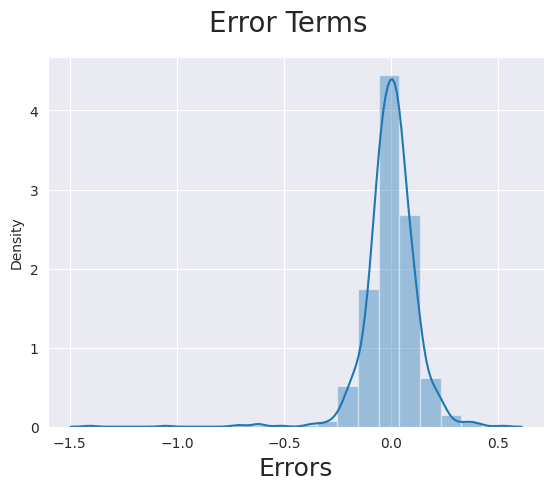

In [155]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - lasso_y_train ), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

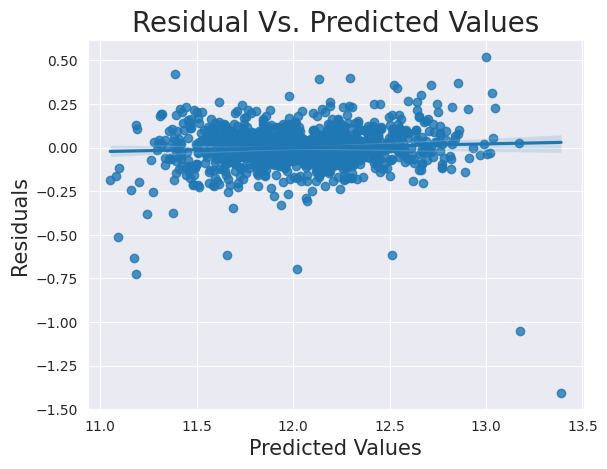

In [156]:
# Plot residuals against the predicted values
sns.regplot(x=lasso_y_train , y=(y_train - lasso_y_train ))
plt.title('Residual Vs. Predicted Values', fontdict={'fontsize': 20})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.ylabel('Residuals', fontdict={'fontsize': 15})
plt.show()

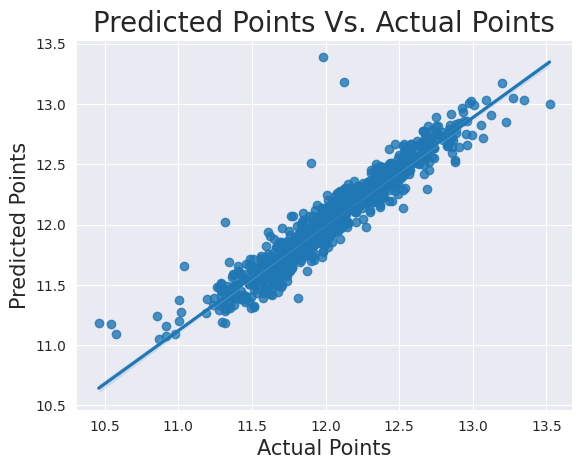

In [157]:
# Plot the predicted value against Actual data
sns.regplot(x=y_train, y=lasso_y_train )
plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
plt.show()

In [158]:
# lasso model parameters
model_parameters = list(lasso_final_model.coef_)
model_parameters.insert(0, lasso_final_model.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
lasso_selected_features = []
for k,v in sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)[1:274]:
    lasso_selected_features.append(v)
sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(11.801, 'constant'),
 (0.182, 'OverallQual_9'),
 (-0.148, 'OverallCond_3'),
 (-0.132, 'OverallQual_3'),
 (0.114, 'GrLivArea'),
 (0.104, 'OverallQual_8'),
 (0.094, 'Neighborhood_Crawfor'),
 (0.09, 'Neighborhood_NridgHt'),
 (0.079, 'Exterior1st_BrkFace'),
 (0.077, 'Neighborhood_StoneBr'),
 (0.076, 'Functional_Typ'),
 (0.074, 'CentralAir_Y'),
 (-0.073, 'MSSubClass_30'),
 (-0.071, 'MSSubClass_160'),
 (-0.061, 'BldgType_Twnhs'),
 (0.061, 'BsmtCond_TA'),
 (0.055, 'Neighborhood_Somerst'),
 (-0.052, 'OverallQual_4'),
 (-0.052, 'OverallCond_4'),
 (-0.049, 'BldgType_TwnhsE'),
 (0.048, 'GarageCars'),
 (0.047, 'Condition1_Norm'),
 (0.046, 'BsmtExposure_Gd'),
 (0.044, 'SaleCondition_Partial'),
 (-0.043, 'MSZoning_RM'),
 (0.043, 'LotConfig_CulDSac'),
 (-0.04, 'OverallCond_5'),
 (-0.039, 'AgeOfHouseWhenSold'),
 (-0.038, 'Neighborhood_Edwards'),
 (-0.038, 'Neighborhood_MeadowV'),
 (0.033, 'YearRemodAdd'),
 (0.033, 'BsmtCond_Gd'),
 (-0.032, 'MSSubClass_60'),
 (0.03, 'Foundation_PConc'),
 (0.028, 'Nei

In [159]:
lasso_selected_features

['OverallQual_9',
 'OverallCond_3',
 'OverallQual_3',
 'GrLivArea',
 'OverallQual_8',
 'Neighborhood_Crawfor',
 'Neighborhood_NridgHt',
 'Exterior1st_BrkFace',
 'Neighborhood_StoneBr',
 'Functional_Typ',
 'CentralAir_Y',
 'MSSubClass_30',
 'MSSubClass_160',
 'BldgType_Twnhs',
 'BsmtCond_TA',
 'Neighborhood_Somerst',
 'OverallQual_4',
 'OverallCond_4',
 'BldgType_TwnhsE',
 'GarageCars',
 'Condition1_Norm',
 'BsmtExposure_Gd',
 'SaleCondition_Partial',
 'MSZoning_RM',
 'LotConfig_CulDSac',
 'OverallCond_5',
 'AgeOfHouseWhenSold',
 'Neighborhood_Edwards',
 'Neighborhood_MeadowV',
 'YearRemodAdd',
 'BsmtCond_Gd',
 'MSSubClass_60',
 'Foundation_PConc',
 'Neighborhood_NoRidge',
 'KitchenQual_TA',
 'BsmtFullBath',
 'KitchenAbvGr',
 'OverallQual_7',
 'GarageType_Attchd',
 'Fireplaces',
 'OverallCond_9',
 'FullBath',
 'OverallQual_5',
 'ExterQual_TA',
 'TotRmsAbvGrd',
 'BsmtFinType1_Unf',
 'OverallCond_7',
 'BsmtFinType1_GLQ',
 'Neighborhood_BrkSide',
 'HouseStyle_1Story',
 'LandContour_HLS',
 

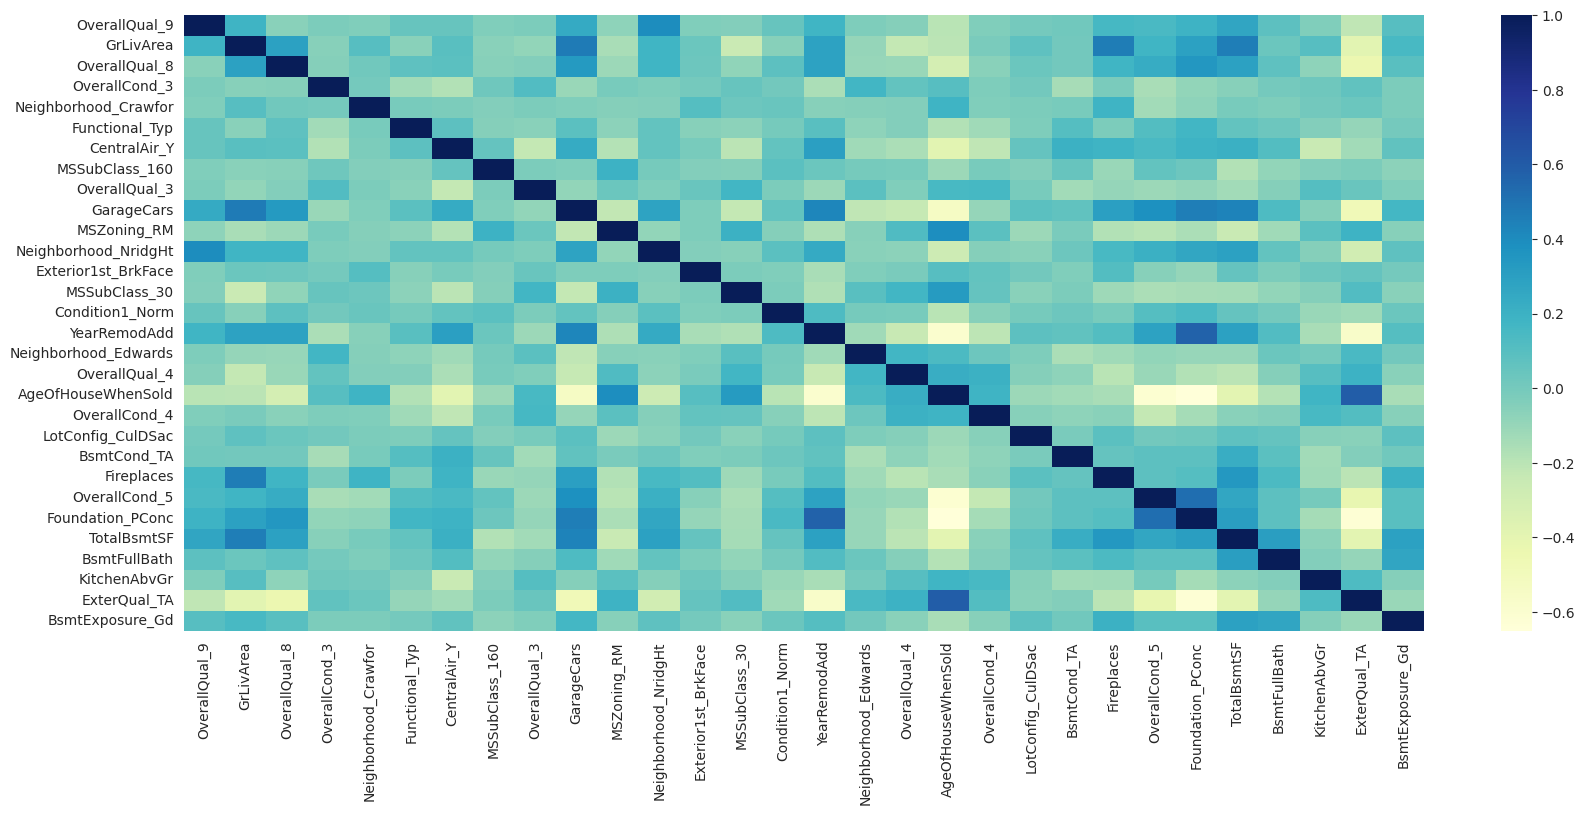

In [169]:
# Checking correlation between the predictors
plt.figure(figsize=(20,8))
# Heatmap
sns.heatmap(df_house[lasso_selected_features].corr(), cmap="YlGnBu", annot=False)
plt.show()

#*Model Selection*

The house dataset contains many correlated variables, Ridge regression may be a better choice. If the dataset contains many irrelevant or redundant features, Lasso regression may be more appropriate. 
If there is multi collinearity in the dataset, lasso tends to make them 0 arbitrarily to resolve it.
If the primary goal is to identify variables impacting price, ridge might be better choice as Lasso might make a few coefficient 0.
It is important to note that the choice between Ridge and Lasso depend on the specific goals of the analysis and the trade-off between bias and variance that is desired.


# **Subjective Questions**

# **Question #1**

In [161]:
params = {'alpha': [20]}

ridge_q1_model, ridge_y_train, ridge_y_predicted, ridge_alpha = BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='ridge')

print('Features and Coefficients\n')
# lasso model parameters
q1_r_model_parameters = list(ridge_q1_model.coef_)
q1_r_model_parameters.insert(0, ridge_q1_model.intercept_)
q1_r_model_parameters = [round(x, 3) for x in q1_r_model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
ridge_selected_features = []
for k,v in sorted(list(zip(q1_r_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)[1:31]:
    ridge_selected_features.append(v)
sorted(list(zip(q1_r_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimum alpha for ridge is 20.000000
ridge  Regression with  20
R2 score (train) :  0.9110824171337317
R2 score (test) :  0.8877341714844567
RMSE (train) :  0.11642588427582716
RMSE (test) :  0.14474225795634246
Features and Coefficients



[(11.827, 'constant'),
 (0.102, 'OverallQual_9'),
 (-0.084, 'OverallCond_3'),
 (-0.078, 'OverallQual_3'),
 (0.073, 'OverallQual_8'),
 (-0.07, 'MSSubClass_30'),
 (0.07, 'Neighborhood_Crawfor'),
 (0.067, 'Neighborhood_NridgHt'),
 (0.066, 'Neighborhood_StoneBr'),
 (0.064, 'Functional_Typ'),
 (-0.063, 'MSSubClass_160'),
 (0.063, 'CentralAir_Y'),
 (0.062, 'Exterior1st_BrkFace'),
 (0.061, 'GrLivArea'),
 (-0.059, 'Neighborhood_Edwards'),
 (-0.055, 'Neighborhood_MeadowV'),
 (0.054, 'BsmtCond_TA'),
 (0.052, 'OverallCond_9'),
 (-0.051, 'BldgType_Twnhs'),
 (-0.049, 'KitchenQual_TA'),
 (0.048, 'LandContour_HLS'),
 (-0.048, 'OverallQual_4'),
 (-0.045, 'BldgType_TwnhsE'),
 (0.044, 'GarageCars'),
 (0.044, 'OverallCond_7'),
 (-0.043, 'AgeOfHouseWhenSold'),
 (-0.043, 'BsmtQual_TA'),
 (0.042, '2ndFlrSF'),
 (0.042, 'MSSubClass_70'),
 (0.042, 'Condition1_Norm'),
 (0.042, 'BsmtExposure_Gd'),
 (0.041, 'OverallCond_8'),
 (-0.041, 'KitchenQual_Gd'),
 (-0.038, 'Condition2_PosN'),
 (0.037, 'LotConfig_CulDSac'),

In [162]:
params = {'alpha': [0.002]}

lasso_q1_model, lasso_y_train, lasso_y_predicted, lasso_alpha = BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='lasso')

print('Features and Coefficients\n')
# lasso model parameters
q1_l_model_parameters = list(lasso_q1_model.coef_)
q1_l_model_parameters.insert(0, lasso_q1_model.intercept_)
q1_l_model_parameters = [round(x, 3) for x in q1_l_model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
lasso_selected_features = []
for k,v in sorted(list(zip(q1_l_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)[1:31]:
    lasso_selected_features.append(v)
sorted(list(zip(q1_l_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimum alpha for lasso is 0.002000
lasso  Regression with  0.002
R2 score (train) :  0.8832445785635682
R2 score (test) :  0.8694992544252058
RMSE (train) :  0.1334118015840723
RMSE (test) :  0.1560551289310471
Features and Coefficients



[(11.859, 'constant'),
 (0.164, 'OverallQual_9'),
 (0.107, 'GrLivArea'),
 (0.101, 'OverallQual_8'),
 (-0.096, 'OverallCond_3'),
 (0.073, 'Neighborhood_Crawfor'),
 (0.073, 'Functional_Typ'),
 (0.068, 'CentralAir_Y'),
 (-0.059, 'MSSubClass_160'),
 (-0.055, 'OverallQual_3'),
 (0.052, 'GarageCars'),
 (-0.049, 'MSZoning_RM'),
 (0.047, 'Neighborhood_NridgHt'),
 (0.047, 'Exterior1st_BrkFace'),
 (-0.04, 'MSSubClass_30'),
 (0.04, 'Condition1_Norm'),
 (0.039, 'YearRemodAdd'),
 (-0.037, 'Neighborhood_Edwards'),
 (-0.037, 'OverallQual_4'),
 (-0.034, 'AgeOfHouseWhenSold'),
 (-0.034, 'OverallCond_4'),
 (0.032, 'LotConfig_CulDSac'),
 (0.03, 'BsmtCond_TA'),
 (0.029, 'Fireplaces'),
 (-0.029, 'OverallCond_5'),
 (0.027, 'Foundation_PConc'),
 (0.026, 'TotalBsmtSF'),
 (0.026, 'BsmtFullBath'),
 (-0.026, 'KitchenAbvGr'),
 (-0.026, 'ExterQual_TA'),
 (0.024, 'BsmtExposure_Gd'),
 (0.024, 'SaleCondition_Partial'),
 (0.022, 'TotRmsAbvGrd'),
 (0.022, 'Neighborhood_Somerst'),
 (0.022, 'BsmtFinType1_GLQ'),
 (0.022, 

In [163]:
q1_model_coefficients = pd.DataFrame(index=X_test.columns)
q1_model_coefficients.rows = X_test.columns

q1_model_coefficients['Ridge (alpha= 10.0)'] = ridge_final_model.coef_
q1_model_coefficients['Lasso (alpha= 0.001)'] = lasso_final_model.coef_
q1_model_coefficients['Ridge (alpha= 20.0)'] = ridge_q1_model.coef_
q1_model_coefficients['Lasso (alpha= 0.002)'] = lasso_q1_model.coef_
pd.set_option('display.max_rows', None)
q1_model_coefficients

,Ridge (alpha= 10.0),Lasso (alpha= 0.001),Ridge (alpha= 20.0),Lasso (alpha= 0.002)
LotFrontage,-0.011106,-0.009687,-0.010279,-0.003886
LotArea,0.015030,0.013413,0.014688,0.012586
YearRemodAdd,0.026564,0.033008,0.029994,0.038632
MasVnrArea,0.002517,0.000000,0.003692,0.000138
BsmtFinSF1,-0.003227,-0.000000,-0.000854,0.000000
BsmtFinSF2,0.008211,0.002204,0.007850,0.000000
BsmtUnfSF,0.002350,0.001199,0.003576,0.000000
TotalBsmtSF,0.001966,0.012956,0.005552,0.025661
1stFlrSF,0.034627,0.000000,0.034454,0.006327
2ndFlrSF,0.043889,0.000000,0.042016,0.000000


In [164]:
q1_model_coefficients.sort_values(by='Lasso (alpha= 0.001)', ascending=False).head(274)

,Ridge (alpha= 10.0),Lasso (alpha= 0.001),Ridge (alpha= 20.0),Lasso (alpha= 0.002)
OverallQual_9,0.126978,0.182371,0.101812,0.163546
GrLivArea,0.062896,0.113789,0.061064,0.107153
OverallQual_8,0.084838,0.104151,0.073044,0.101425
Neighborhood_Crawfor,0.080283,0.093793,0.069518,0.072690
Neighborhood_NridgHt,0.081655,0.090271,0.067009,0.046993
Exterior1st_BrkFace,0.074124,0.078852,0.062352,0.047299
Neighborhood_StoneBr,0.091939,0.077482,0.066072,0.000000
Functional_Typ,0.068743,0.075541,0.064461,0.072942
CentralAir_Y,0.070726,0.073756,0.063305,0.067910
BsmtCond_TA,0.061781,0.061003,0.053887,0.030349


#** Question #2**

In [165]:

#TOP 5
final_model_coefficients.sort_values(by='Lasso (alpha= 0.001)', ascending=False).head(5)

,Ridge (alpha= 7.0),Lasso (alpha= 0.001)
OverallQual_9,0.126978,0.182371
GrLivArea,0.062896,0.113789
OverallQual_8,0.084838,0.104151
Neighborhood_Crawfor,0.080283,0.093793
Neighborhood_NridgHt,0.081655,0.090271


In [166]:
params = {'alpha': [0.000001, 0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000]}

X_train_q3 = X_train.drop(['OverallQual_9', 'GrLivArea', 'OverallQual_8', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt'], axis=1)
X_test_q3 = X_test.drop(['OverallQual_9', 'GrLivArea', 'OverallQual_8', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt'], axis=1)

lasso_model_q3, lasso_y_train_q3, lasso_y_predicted_q3, lasso_alpha_q3 = BuildRidgeOrLassoModel(X_train_q3, y_train, X_test_q3, params, model='lasso')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimum alpha for lasso is 0.000100
lasso  Regression with  0.0001
R2 score (train) :  0.9350547669421787
R2 score (test) :  0.876979605578002
RMSE (train) :  0.09950143881713364
RMSE (test) :  0.15151656219480675


In [167]:
q3_model_coefficients = pd.DataFrame(index=X_test_q3.columns)
q3_model_coefficients.rows = X_test_q3.columns

q3_model_coefficients['Lasso (alpha= 0.0001)'] = lasso_model_q3.coef_
pd.set_option('display.max_rows', None)
q3_model_coefficients.sort_values(by='Lasso (alpha= 0.0001)', ascending=False).head(5)

,Lasso (alpha= 0.0001)
RoofMatl_WdShngl,1.096494
RoofMatl_CompShg,1.009892
RoofMatl_WdShake,0.981634
RoofMatl_Tar&Grv,0.966680
RoofMatl_Roll,0.909017
